# Final Data

## 0. Data load

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/기상청/데이터')

In [ ]:
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
from tqdm.notebook import tqdm
tqdm.pandas()

import random
from functools import reduce

import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
%matplotlib inline

rc('font', family='MalgunGothic')
plt.rcParams['axes.unicode_minus'] = False

import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import GradientBoostingRegressor

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [ ]:
cluster = pd.read_csv('cluster_dtw_scaling.csv', encoding='CP949')
trend = pd.read_csv('final_0606.csv', encoding='CP949')
weather = pd.read_csv('weather_final.csv', encoding='cp949')

In [ ]:
cluster.head(2)

,sm_cat,01-01,01-02,01-03,01-04,01-05,01-06,01-07,01-08,01-09,01-10,01-11,01-12,01-13,01-14,01-15,01-16,01-17,01-18,01-19,01-20,01-21,01-22,01-23,01-24,01-25,01-26,01-27,01-28,01-29,01-30,01-31,02-01,02-02,02-03,02-04,02-05,02-06,02-07,02-08,...,11-23,11-24,11-25,11-26,11-27,11-28,11-29,11-30,12-01,12-02,12-03,12-04,12-05,12-06,12-07,12-08,12-09,12-10,12-11,12-12,12-13,12-14,12-15,12-16,12-17,12-18,12-19,12-20,12-21,12-22,12-23,12-24,12-25,12-26,12-27,12-28,12-29,12-30,12-31,cluster
0,가스온수기,-0.403750,0.482756,-0.403750,-0.40375,-0.403750,-0.403750,0.482756,-0.403750,0.482756,0.482756,-0.40375,0.719709,-0.403750,1.369263,0.482756,1.606215,-0.403750,0.719709,-0.403750,-0.403750,-0.403750,-0.403750,-0.403750,-0.403750,-0.403750,-0.403750,-0.403750,1.843168,0.482756,-0.403750,-0.403750,1.606215,-0.403750,-0.403750,-0.403750,0.719709,1.606215,1.369263,-0.403750,...,1.606215,-0.403750,0.482756,-0.40375,0.482756,0.482756,-0.403750,2.255769,0.719709,-0.403750,0.482756,-0.403750,-0.403750,0.482756,0.482756,-0.40375,0.482756,-0.403750,-0.403750,0.719709,0.482756,0.482756,-0.403750,2.966627,0.719709,0.719709,0.719709,0.719709,-0.403750,-0.403750,-0.403750,-0.403750,-0.403750,-0.403750,0.482756,-0.403750,-0.40375,-0.40375,-0.403750,0
1,가열식 가습기,2.034589,1.327837,1.533372,1.41079,0.556221,1.201658,1.111509,1.320641,1.601883,0.970888,0.48771,0.372324,0.192026,0.329049,0.559819,0.119917,0.123515,0.119917,-0.251475,-0.017106,0.047807,0.325451,0.556221,0.549025,0.574261,-0.319986,0.206468,0.988927,0.689646,0.393962,0.073043,-0.114452,-0.345222,-0.139688,-0.143286,-0.301946,-0.182963,0.141554,0.300215,...,0.711283,1.151186,1.879527,1.65960,2.286997,1.454066,1.136745,0.729274,0.538181,2.085061,2.651143,2.135533,2.618711,4.115021,1.792976,2.17521,3.639137,3.372336,2.748537,2.467295,2.005755,1.169225,1.320641,2.589877,1.558656,1.273767,1.861487,1.479302,0.538181,1.259326,1.627119,1.158382,1.147588,1.136745,2.323076,0.924014,1.14399,1.18002,0.422796,1


In [ ]:
trend.head(2)

,Unnamed: 0,date,sex,age,big_cat,sm_cat,qty,cnt,ratio,오늘날씨,미세먼지,오늘 비,기상정보,태풍정보,avg_ta,max_ta,min_ta,rn_day,rn_hr1,avg_ws,PM10,PM25,hm_max,sum_ss_hr,max_pa,분기,요일,공휴일명,공휴일여부,주말여부,계절
0,0,2018-01-01,F,20,식품,가공란,37.0,0.480964,0.0,10.69387,4.09137,0.0,0.00000,0.04440,0.885198,5.464146,-2.88074,0.0,0.0,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,1월1일,1,0,3
1,1,2018-01-01,F,30,식품,가공란,16.0,0.480964,0.0,12.42969,6.35294,0.0,0.51282,0.42417,0.885198,5.464146,-2.88074,0.0,0.0,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,1월1일,1,0,3


In [ ]:
weather.head(2)

,날짜,지점번호,평균기온,최고기온,최저기온,일별강수량,1시간최대강수량,평균풍속,지역,PM10,PM25,1시간최대습도,일조시간합,최고현지기압,연,월,일,분기,요일,공휴일명,공휴일여부,주말여부,계절,체감온도,열지수,폭염여부,강수여부
0,2018-01-01,105,1.3,5.7,-2.1,0.0,0.0,3.7,강릉,20.066667,13.400000,25.4,57.9,1023.0,2018,1,1,1,0,1월1일,1,0,3,7.502056,-39.701524,0,0
1,2018-01-01,112,-0.3,2.7,-2.7,0.0,0.0,1.6,인천,37.518681,18.641758,67.2,53.8,1020.3,2018,1,1,1,0,1월1일,1,0,3,9.992379,-42.924922,0,0


## 1. Merge

In [ ]:
app = trend[trend['big_cat']=='냉난방가전'].reset_index(drop=True).drop(['Unnamed: 0'],axis=1)

In [ ]:
app.head(2)

,date,sex,age,big_cat,sm_cat,qty,cnt,ratio,오늘날씨,미세먼지,오늘 비,기상정보,태풍정보,avg_ta,max_ta,min_ta,rn_day,rn_hr1,avg_ws,PM10,PM25,hm_max,sum_ss_hr,max_pa,분기,요일,공휴일명,공휴일여부,주말여부,계절
0,2018-01-01,F,20,냉난방가전,가스온수기,0.0,0.0,10.52631,10.69387,4.09137,0.0,0.00000,0.04440,0.885198,5.464146,-2.88074,0.0,0.0,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,1월1일,1,0,3
1,2018-01-01,F,30,냉난방가전,가스온수기,0.0,0.0,19.04761,12.42969,6.35294,0.0,0.51282,0.42417,0.885198,5.464146,-2.88074,0.0,0.0,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,1월1일,1,0,3


In [ ]:
def cluster_buy_df(c) : 
    clusterdf = cluster[cluster["cluster"] == c]
    df = app[app.sm_cat.isin(list(clusterdf["sm_cat"]))] 
    return df.reset_index(drop=True)

In [ ]:
cluster0 = cluster_buy_df(0)
cluster1 = cluster_buy_df(1)
cluster2 = cluster_buy_df(2)

In [ ]:
def region_weather(지역):
    weather_true = weather.drop(['연', '월', '일', '분기', '요일', '공휴일명', '공휴일여부', '주말여부', '계절'], axis=1) # weather_final
    weather1 = pd.pivot_table(weather_true[weather_true['지역'].isin(지역)], index='날짜', columns='지역').reset_index(drop=True)
    weather1.columns = [l+"_"+w for l,w in zip(weather1.columns.get_level_values(1), weather1.columns.get_level_values(0))]
    weather1['날짜'] = weather['날짜'].unique()
    return weather1

In [ ]:
cluster0_region = region_weather(['서울','천안','수원'])
cluster1_region = region_weather(['서울','대전','인천'])
cluster2_region = region_weather(['서울','대구','강릉'])

In [ ]:
cluster0_region.head(2)

,서울_1시간최대강수량,수원_1시간최대강수량,천안_1시간최대강수량,서울_1시간최대습도,수원_1시간최대습도,천안_1시간최대습도,서울_PM10,수원_PM10,천안_PM10,서울_PM25,수원_PM25,천안_PM25,서울_강수여부,수원_강수여부,천안_강수여부,서울_열지수,수원_열지수,천안_열지수,서울_일별강수량,수원_일별강수량,천안_일별강수량,서울_일조시간합,수원_일조시간합,천안_일조시간합,서울_지점번호,수원_지점번호,천안_지점번호,서울_체감온도,수원_체감온도,천안_체감온도,서울_최고기온,수원_최고기온,천안_최고기온,서울_최고현지기압,수원_최고현지기압,천안_최고현지기압,서울_최저기온,수원_최저기온,천안_최저기온,서울_평균기온,수원_평균기온,천안_평균기온,서울_평균풍속,수원_평균풍속,천안_평균풍속,서울_폭염여부,수원_폭염여부,천안_폭염여부,날짜
0,0.0,0.0,0.0,57.1,84.7,88.8,42.307692,42.782895,51.750000,21.470696,21.375000,26.444444,0,0,0,-44.993999,-45.791893,-48.073016,0.0,0.0,0.0,51.6,52.7,50.5,108,119,232,9.649709,10.136402,9.582651,3.8,4.7,3.8,1018.1,1025.1,1019.1,-5.1,-6.9,-8.5,-1.3,-1.7,-2.8,1.4,1.0,0.9,0,0,0,2018-01-01
1,0.0,0.0,0.0,71.6,95.4,92.2,40.470588,41.343949,59.984848,22.711397,23.936306,35.196970,0,0,0,-46.012971,-45.780499,-47.652552,0.0,0.0,0.0,48.4,35.8,10.8,108,119,232,8.521194,8.980173,9.718370,1.8,3.3,2.9,1019.6,1026.3,1020.2,-4.3,-5.7,-8.1,-1.8,-1.7,-2.6,1.8,1.6,0.9,0,0,0,2018-01-02


In [ ]:
clster0_merge = cluster0.merge(cluster0_region, left_on="date", right_on="날짜")
clster1_merge = cluster1.merge(cluster1_region, left_on="date", right_on="날짜")
clster2_merge = cluster2.merge(cluster2_region, left_on="date", right_on="날짜")

In [ ]:
clster0_merge.head(2)

,date,sex,age,big_cat,sm_cat,qty,cnt,ratio,오늘날씨,미세먼지,오늘 비,기상정보,태풍정보,avg_ta,max_ta,min_ta,rn_day,rn_hr1,avg_ws,PM10,PM25,hm_max,sum_ss_hr,max_pa,분기,요일,공휴일명,공휴일여부,주말여부,계절,서울_1시간최대강수량,수원_1시간최대강수량,천안_1시간최대강수량,서울_1시간최대습도,수원_1시간최대습도,천안_1시간최대습도,서울_PM10,수원_PM10,천안_PM10,서울_PM25,수원_PM25,천안_PM25,서울_강수여부,수원_강수여부,천안_강수여부,서울_열지수,수원_열지수,천안_열지수,서울_일별강수량,수원_일별강수량,천안_일별강수량,서울_일조시간합,수원_일조시간합,천안_일조시간합,서울_지점번호,수원_지점번호,천안_지점번호,서울_체감온도,수원_체감온도,천안_체감온도,서울_최고기온,수원_최고기온,천안_최고기온,서울_최고현지기압,수원_최고현지기압,천안_최고현지기압,서울_최저기온,수원_최저기온,천안_최저기온,서울_평균기온,수원_평균기온,천안_평균기온,서울_평균풍속,수원_평균풍속,천안_평균풍속,서울_폭염여부,수원_폭염여부,천안_폭염여부,날짜
0,2018-01-01,F,20,냉난방가전,가스온수기,0.0,0.0,10.52631,10.69387,4.09137,0.0,0.00000,0.04440,0.885198,5.464146,-2.88074,0.0,0.0,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,1월1일,1,0,3,0.0,0.0,0.0,57.1,84.7,88.8,42.307692,42.782895,51.75,21.470696,21.375,26.444444,0,0,0,-44.993999,-45.791893,-48.073016,0.0,0.0,0.0,51.6,52.7,50.5,108,119,232,9.649709,10.136402,9.582651,3.8,4.7,3.8,1018.1,1025.1,1019.1,-5.1,-6.9,-8.5,-1.3,-1.7,-2.8,1.4,1.0,0.9,0,0,0,2018-01-01
1,2018-01-01,F,30,냉난방가전,가스온수기,0.0,0.0,19.04761,12.42969,6.35294,0.0,0.51282,0.42417,0.885198,5.464146,-2.88074,0.0,0.0,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,1월1일,1,0,3,0.0,0.0,0.0,57.1,84.7,88.8,42.307692,42.782895,51.75,21.470696,21.375,26.444444,0,0,0,-44.993999,-45.791893,-48.073016,0.0,0.0,0.0,51.6,52.7,50.5,108,119,232,9.649709,10.136402,9.582651,3.8,4.7,3.8,1018.1,1025.1,1019.1,-5.1,-6.9,-8.5,-1.3,-1.7,-2.8,1.4,1.0,0.9,0,0,0,2018-01-01


In [ ]:
clster0_merge.drop(['날짜','공휴일명'],axis=1,inplace=True)
clster1_merge.drop(['날짜','공휴일명'],axis=1,inplace=True)
clster2_merge.drop(['날짜','공휴일명'],axis=1,inplace=True)

In [ ]:
print(clster0_merge.shape)
print(clster1_merge.shape)
print(clster2_merge.shape)

(71385, 79)
(88159, 79)
(72078, 79)


In [ ]:
def get_dummies(data, var_list):
    # var_list = ['var1', 'var2']
    for var in var_list:
        if var=='sex':
            data[var] = pd.get_dummies(data[var]).iloc[:,:1] # F(1), M(0)
        else:
            data = pd.concat([data.drop(var, axis=1), pd.get_dummies(data[var], prefix=var, drop_first=True)], axis=1)
    return data

In [ ]:
def prepro(data):
    # 날짜
    data["date"] = pd.to_datetime(data['date'], format='%Y-%m-%d')
    data["year"] = data["date"].dt.year
    data["month"] = data["date"].dt.month
    data = data.drop(["big_cat"], axis=1) 
    # 범주형
    data['sex'] = data['sex'].apply(lambda x: 1 if x=='F' else 0)
    age1 = pd.get_dummies(data['age'], prefix='age', drop_first=True)
    data = pd.concat([data, age1], axis=1)
    data = data.drop(["age"], axis=1) 
    # 소분류
    cat = pd.get_dummies(data['sm_cat'])
    data = pd.concat([data, cat], axis=1)
    data = data.drop(["sm_cat"], axis=1) 
    return data

In [ ]:
clster0_prepro = prepro(clster0_merge)
clster1_prepro = prepro(clster1_merge)
clster2_prepro = prepro(clster2_merge)

In [ ]:
print(clster0_prepro.shape)
print(clster1_prepro.shape)
print(clster2_prepro.shape)

(71385, 93)
(88159, 95)
(72078, 92)


In [ ]:
clster2_prepro.tail(2)

,date,sex,qty,cnt,ratio,오늘날씨,미세먼지,오늘 비,기상정보,태풍정보,avg_ta,max_ta,min_ta,rn_day,rn_hr1,avg_ws,PM10,PM25,hm_max,sum_ss_hr,max_pa,분기,요일,공휴일여부,주말여부,계절,강릉_1시간최대강수량,대구_1시간최대강수량,서울_1시간최대강수량,강릉_1시간최대습도,대구_1시간최대습도,서울_1시간최대습도,강릉_PM10,대구_PM10,서울_PM10,강릉_PM25,대구_PM25,서울_PM25,강릉_강수여부,대구_강수여부,...,서울_지점번호,강릉_체감온도,대구_체감온도,서울_체감온도,강릉_최고기온,대구_최고기온,서울_최고기온,강릉_최고현지기압,대구_최고현지기압,서울_최고현지기압,강릉_최저기온,대구_최저기온,서울_최저기온,강릉_평균기온,대구_평균기온,서울_평균기온,강릉_평균풍속,대구_평균풍속,서울_평균풍속,강릉_폭염여부,대구_폭염여부,서울_폭염여부,year,month,age_30,age_40,age_50,age_60,냉풍기,멀티형 에어컨,벽걸이 에어컨,벽걸이형 선풍기,스탠드형 에어컨,업소용 선풍기,에어컨 리모컨,이동형 에어컨,제습기,카페트매트,탁상/USB 선풍기,휴대용 선풍기
72076,2019-12-31,0,0.0,0.0,0.26624,37.03963,1.60475,0.0,4.90956,0.17814,-3.153771,0.872542,-5.469094,0.0,0.005885,3.414438,19.590719,10.860786,61.658,47.797865,927.43791,4,1,0,0,3,0.0,0.0,0.0,48.5,59.4,67.6,20.869565,17.600536,25.641304,10.217391,11.142091,14.782609,0,0,...,108,3.742576,1.28169,1.016984,1.8,2.6,-4.5,1023.103448,1026.9,1025.9,-5.6,-5.1,-10.9,-2.4,-2.5,-7.9,4.0,5.2,3.1,0,0,0,2019,12,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
72077,2019-12-31,0,0.0,0.0,0.61728,67.48388,4.62476,0.0,19.13043,0.69605,-3.153771,0.872542,-5.469094,0.0,0.005885,3.414438,19.590719,10.860786,61.658,47.797865,927.43791,4,1,0,0,3,0.0,0.0,0.0,48.5,59.4,67.6,20.869565,17.600536,25.641304,10.217391,11.142091,14.782609,0,0,...,108,3.742576,1.28169,1.016984,1.8,2.6,-4.5,1023.103448,1026.9,1025.9,-5.6,-5.1,-10.9,-2.4,-2.5,-7.9,4.0,5.2,3.1,0,0,0,2019,12,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


## 2. Data for Modeling

### 2-1. Train Test Split

In [ ]:
def sampling(data):
    # 랜덤으로 요일 선택
    np.random.seed(1234)
    sample_day = []; sample_idx = []
    count = 730//7 
    day_list = day_list = [1,2,3,4,5,6,7]
    sample_list = [random.choice(day_list) for i in range(count)]

    # 랜덤으로 선택된 요일의 날짜
    start = datetime.datetime(2018, 1, 1)
    for days in sample_list:
        sample_day.append(start + datetime.timedelta(days = days))
        start = start + datetime.timedelta(weeks = 1)

    # 샘플링
    for date in sample_day:
        sample_idx.extend(data[data['date']==date].index)
        
    all_idx = data.index.tolist()
    train_idx = list(set(all_idx) - set(sample_idx))
    return data.iloc[train_idx].reset_index(drop=True), data.iloc[sample_idx].reset_index(drop=True)

In [ ]:
train_0, test_0 = sampling(clster0_prepro)

In [ ]:
train_0, test_0 = sampling(clster0_prepro)
train_1, test_1 = sampling(clster1_prepro)
train_2, test_2 = sampling(clster2_prepro)

In [ ]:
print(train_0.shape, test_0.shape)
print(train_1.shape, test_1.shape)
print(train_2.shape, test_2.shape)

(61174, 92) (10211, 92)
(75623, 94) (12536, 94)
(61852, 91) (10226, 91)


In [ ]:
# date drop
train_0.drop(['date'],axis=1,inplace=True);test_0.drop(['date'],axis=1,inplace=True)
train_1.drop(['date'],axis=1,inplace=True);test_1.drop(['date'],axis=1,inplace=True)
train_2.drop(['date'],axis=1,inplace=True);test_2.drop(['date'],axis=1,inplace=True)

### 2-2. Standardization

In [ ]:
train_X_0, train_Y_0 = train_0.drop(['qty'],axis=1), train_0.qty
train_X_1, train_Y_1 = train_1.drop(['qty'],axis=1), train_1.qty
train_X_2, train_Y_2 = train_2.drop(['qty'],axis=1), train_2.qty
test_X_0, test_Y_0 = test_0.drop(['qty'],axis=1), test_0.qty
test_X_1, test_Y_1 = test_1.drop(['qty'],axis=1), test_1.qty
test_X_2, test_Y_2 = test_2.drop(['qty'],axis=1), test_2.qty

In [ ]:
std_scaler = StandardScaler()
train_std_0 = std_scaler.fit_transform(train_X_0);test_std_0 = std_scaler.transform(test_X_0)
train_std_1 = std_scaler.fit_transform(train_X_1);test_std_1 = std_scaler.transform(test_X_1)
train_std_2 = std_scaler.fit_transform(train_X_2);test_std_2 = std_scaler.transform(test_X_2)

In [ ]:
train_std_Y_0 = (train_Y_0-train_Y_0.mean())/train_Y_0.std();test_std_Y_0=(test_Y_0-train_Y_0.mean())/train_Y_0.std()
train_std_Y_1 = (train_Y_1-train_Y_1.mean())/train_Y_1.std();test_std_Y_1=(test_Y_1-train_Y_1.mean())/train_Y_1.std()
train_std_Y_2 = (train_Y_2-train_Y_2.mean())/train_Y_2.std();test_std_Y_2=(test_Y_2-train_Y_2.mean())/train_Y_2.std()

## 3. Modeling

In [ ]:
xgb_model = xgb.XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=100) 
xgb_model.fit(train_std_0, train_std_Y_0)
pred_Y_0 = xgb_model.predict(test_std_0)
print(mean_squared_error(test_std_Y_0, pred_Y_0))

[11:59:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.1783068860155677


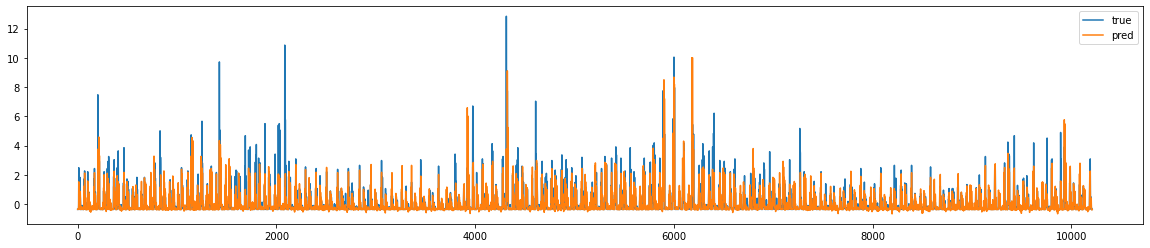

In [ ]:
plt.figure(figsize=(20,4))
plt.plot(test_std_Y_0, label='true')
plt.plot(pred_Y_0, label='pred')
plt.legend(loc = 'best')
plt.show()

In [ ]:
pd.DataFrame({
    'col' : train_X_0.columns, 'feature importance' : xgb_model.feature_importances_
}).sort_values('feature importance', ascending=False)[:10]

,col,feature importance
30,서울_PM10,0.099696
1,cnt,0.066711
72,year,0.052184
60,서울_최저기온,0.051840
75,age_40,0.047723
82,보일러,0.047483
79,공기정화 용품,0.043337
74,age_30,0.037934
14,PM10,0.036362
77,age_60,0.033181


In [ ]:
xgb_model.fit(train_std_1, train_std_Y_1)
pred_Y_1 = xgb_model.predict(test_std_1)
print(mean_squared_error(test_std_Y_1, pred_Y_1))

[12:00:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.2397325363980318


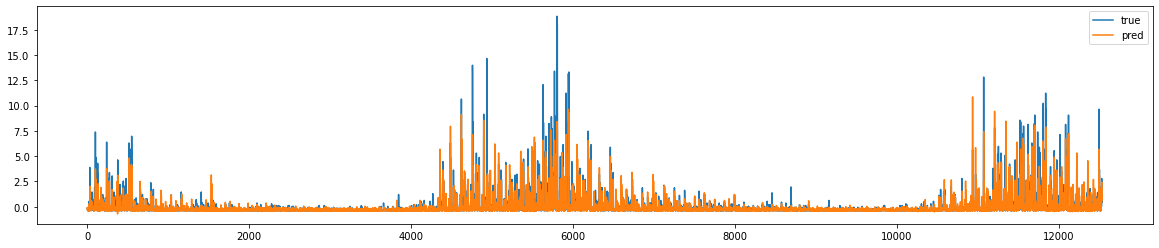

In [ ]:
plt.figure(figsize=(20,4))
plt.plot(test_std_Y_1, label='true')
plt.plot(pred_Y_1, label='pred')
plt.legend(loc = 'best')
plt.show()

In [ ]:
pd.DataFrame({
    'col' : train_X_1.columns, 'feature importance' : xgb_model.feature_importances_
}).sort_values('feature importance', ascending=False)[:10]

,col,feature importance
88,전기장판,0.128961
74,age_30,0.059475
1,cnt,0.054239
73,month,0.051229
2,ratio,0.049288
89,초음파식 가습기,0.046247
77,age_60,0.045313
75,age_40,0.038712
62,인천_최저기온,0.031454
23,계절,0.029417


In [ ]:
xgb_model.fit(train_std_2, train_std_Y_2)
pred_Y_2 = xgb_model.predict(test_std_2)
print(mean_squared_error(test_std_Y_2, pred_Y_2))

[12:01:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.2417217546576625


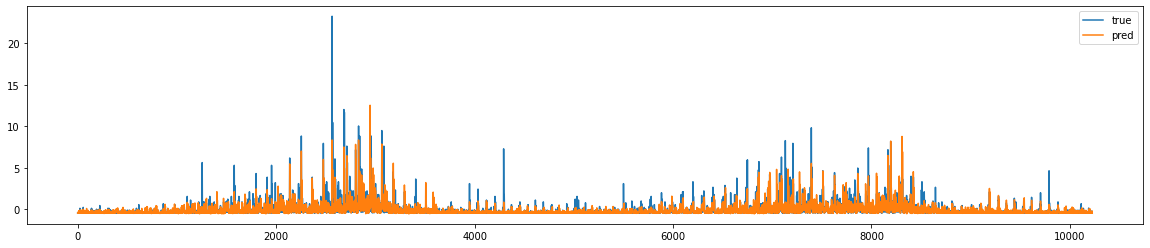

In [ ]:
plt.figure(figsize=(20,4))
plt.plot(test_std_Y_2, label='true')
plt.plot(pred_Y_2, label='pred')
plt.legend(loc = 'best')
plt.show()

In [ ]:
pd.DataFrame({
    'col' : train_X_2.columns, 'feature importance' : xgb_model.feature_importances_
}).sort_values('feature importance', ascending=False)[:10]

,col,feature importance
89,휴대용 선풍기,0.067798
9,max_ta,0.063521
1,cnt,0.049118
74,age_30,0.041517
77,age_60,0.041209
67,대구_평균풍속,0.040444
76,age_50,0.036277
10,min_ta,0.034959
46,대구_일조시간합,0.030020
39,강릉_열지수,0.029814


### 3-2. LGBM

In [ ]:
lgb_model = lgb.LGBMRegressor() 
lgb_model.fit(train_std_0, train_std_Y_0)
pred_Y_0 = lgb_model.predict(test_std_0)
print(mean_squared_error(test_std_Y_0, pred_Y_0))

0.1495245751945071


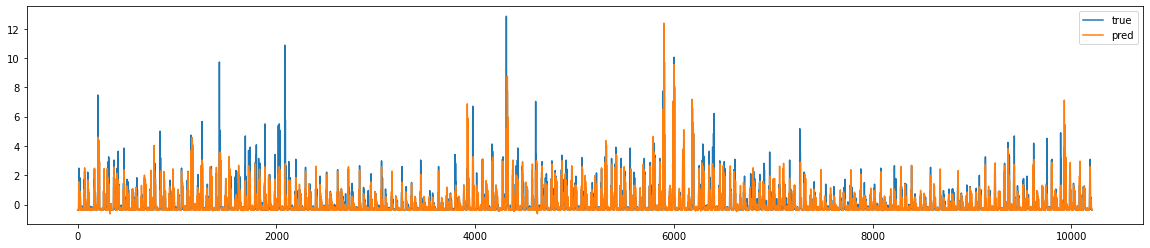

In [ ]:
plt.figure(figsize=(20,4))
plt.plot(test_std_Y_0, label='true')
plt.plot(pred_Y_0, label='pred')
plt.legend(loc = 'best')
plt.show()

In [ ]:
pd.DataFrame({
    'col' : train_X_0.columns, 'feature importance' : lgb_model.feature_importances_
}).sort_values('feature importance', ascending=False)[:10]

,col,feature importance
1,cnt,462
2,ratio,205
4,미세먼지,161
74,age_30,120
87,온열매트,98
75,age_40,97
20,요일,95
6,기상정보,92
0,sex,89
30,서울_PM10,80


In [ ]:
lgb_model.fit(train_std_1, train_std_Y_1)
pred_Y_1 = lgb_model.predict(test_std_1)
print(mean_squared_error(test_std_Y_1, pred_Y_1))

0.2130401202104137


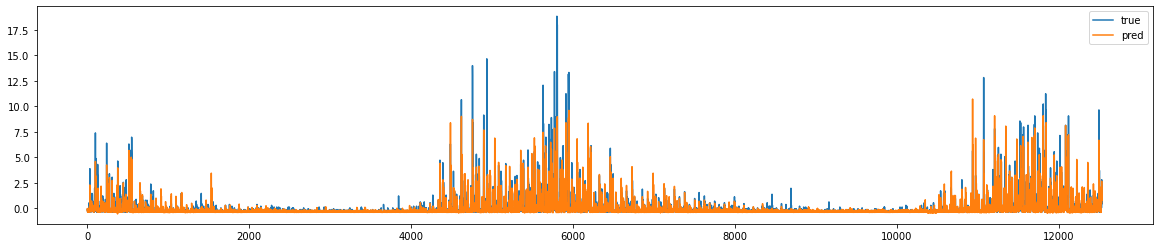

In [ ]:
plt.figure(figsize=(20,4))
plt.plot(test_std_Y_1, label='true')
plt.plot(pred_Y_1, label='pred')
plt.legend(loc = 'best')
plt.show()

In [ ]:
pd.DataFrame({
    'col' : train_X_1.columns, 'feature importance' : lgb_model.feature_importances_
}).sort_values('feature importance', ascending=False)[:10]

,col,feature importance
1,cnt,391
2,ratio,276
0,sex,134
74,age_30,128
75,age_40,125
89,초음파식 가습기,124
82,복합식 가습기,97
20,요일,88
18,max_pa,82
84,온수매트,67


In [ ]:
lgb_model.fit(train_std_2, train_std_Y_2)
pred_Y_2 = lgb_model.predict(test_std_2)
print(mean_squared_error(test_std_Y_2, pred_Y_2))

0.23468799680514038


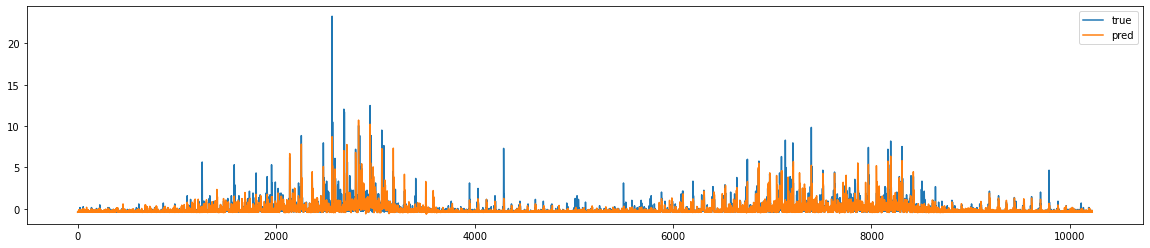

In [ ]:
plt.figure(figsize=(20,4))
plt.plot(test_std_Y_2, label='true')
plt.plot(pred_Y_2, label='pred')
plt.legend(loc = 'best')
plt.show()

In [ ]:
pd.DataFrame({
    'col' : train_X_2.columns, 'feature importance' : lgb_model.feature_importances_
}).sort_values('feature importance', ascending=False)[:10]

,col,feature importance
1,cnt,397
2,ratio,310
89,휴대용 선풍기,109
74,age_30,106
75,age_40,102
4,미세먼지,99
18,max_pa,98
0,sex,89
7,태풍정보,83
77,age_60,80
